<a href="https://colab.research.google.com/github/joshthesteez/Uber-Data-Analysis/blob/main/UberAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GOALS**

1.  **User Behavior Analysis**


*   What are the most common purposes for Uber rides?
*   How often do users take Uber rides? Are there any patterns based on time of day, day of the week, or month?


2.   **Ride Metrics**


*   What is the average distance and duration of Uber rides?
*   Is there a correlation between ride distance and duration?
* How do ride metrics vary across different purposes (e.g. *business vs. personal rides*)


3.   **Geographical Insights**


*   Which locations or routes are the most popular for Uber rides?
*   Is there a relationship between ride location and purpose?


4.   **Seasonal Trends**


*   When does the demand for Uber rides spike? When does it drop?






# Imports and File Structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

# replace with your file path if you want to run this on your machine
file_path = "YOUR_PATH_HERE"

if not os.path.exists(file_path):
    print(f"ERROR: '{file_path}' does not exist")
else:
    # read the dataset into a pandas dataframe and inspect its properties
    dataset = pd.read_csv(file_path)


    print("dataset before preprocessing: \n")
    print(dataset.head())
    print(f"Shape: {dataset.shape}\n")
    print(dataset.info())



dataset before preprocessing: 

         START_DATE          END_DATE  CATEGORY        START             STOP  \
0  01-01-2016 21:11  01-01-2016 21:17  Business  Fort Pierce      Fort Pierce   
1  01-02-2016 01:25  01-02-2016 01:37  Business  Fort Pierce      Fort Pierce   
2  01-02-2016 20:25  01-02-2016 20:38  Business  Fort Pierce      Fort Pierce   
3  01-05-2016 17:31  01-05-2016 17:45  Business  Fort Pierce      Fort Pierce   
4  01-06-2016 14:42  01-06-2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              NaN  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  
Shape: (1156, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non

# Data Preprocessing
We need to:

1.   Get rid of all the null values in the **PURPOSE** column
2.   Change the **START_DATE** and **END_DATE** columns to ***datetime*** format
3.   Split the **START_DATE** and **END_DATE** columns into into a *date* and *time* column and establish 4 '*time zones*' for the day
4.   Drop any duplicate rows and rows with null values



In [213]:
  # replace null values in PURPOSE column with NOT values
  dataset['PURPOSE'].fillna(value="NOT", inplace=True)
  # change the datatype of START_DATE & END_DATE to date_time format
  dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], errors='coerce')
  dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], errors='coerce')

  # split the START_DATE and END_DATE columns into date and time columns
  dataset['date'] = pd.DatetimeIndex(dataset['START_DATE']).date
  dataset['time'] = pd.DatetimeIndex(dataset['START_DATE']).hour

  # establish 4 time zones for the day
  dataset['day-night'] = pd.cut(x=dataset['time'],
                                  bins = [0,10,15,19,24],
                                  labels = ['Morning', 'Afternoon', 'Evening', 'Night'])

  # drop null values and duplicate columns
  dataset.dropna(inplace=True)
  dataset.drop_duplicates(inplace=True)

  print("dataset after preprocessing: \n")
  print(dataset.head())
  print(f"Shape: {dataset.shape}\n")
  print(dataset.info())

dataset after preprocessing: 

           START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE        date  time  day-night   DAY  \
0      Fort Pierce      5   Meal/Entertain  2016-01-01    21      Night   Fri   
1      Fort Pierce      5              NOT  2016-01-02     1    Morning   Sat   
2      Fort Pierce      4  Errand/Supplies  2016-01-02    20      Night   Sat   
3      Fort Pierce      4          Meeting  2016-01-05    17    Evening  Tues   
4  West Palm Beach     63   Customer Visit  2016-01-06    14  Afternoon   Wed   

   MONTH                           ROUTE  
0      1      Fort Pierce -> F

# Data Visualization

First lets look at how many unique values are located in columns with object datatypes, these will be our '*categorical*' columns

In [3]:
obj = (dataset.dtypes == 'object') & (dataset.dtypes == 'category')
object_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

unique_vals = {}
for col in object_cols:
    try:
        unique_vals[col] = dataset[col].unique().size
        print(f"Unique values in column '{col}': {unique_vals[col]}")
    except KeyError as e:
        print(f"Error: Column '{col}' not found in the DataFrame.")
        continue

Unique values in column 'CATEGORY': 2
Unique values in column 'START': 108
Unique values in column 'STOP': 112
Unique values in column 'PURPOSE': 7
Unique values in column 'date': 113
Unique values in column 'day-night': 4


These unique values tell us how much variability exists in the object columns:

A ***high*** count suggests that there is a lot of diversity in the data of that respective column, so for categorical data like we have, we see that there are a lot of options, especially in our location and date columns.

Conversely, a ***low*** unique value count, as seen in our **CATEGORY** and **PURPOSE** column shows us that there are not a lot of classifications for our data, so there will be less variance and more consistency within these columns.

# User Behavior Analysis

Looking at the **CATEGORY** column, we see that there are two options: ***Business*** and ***Personal***

Lets compare the amount of trips taken for Business vs. Personal

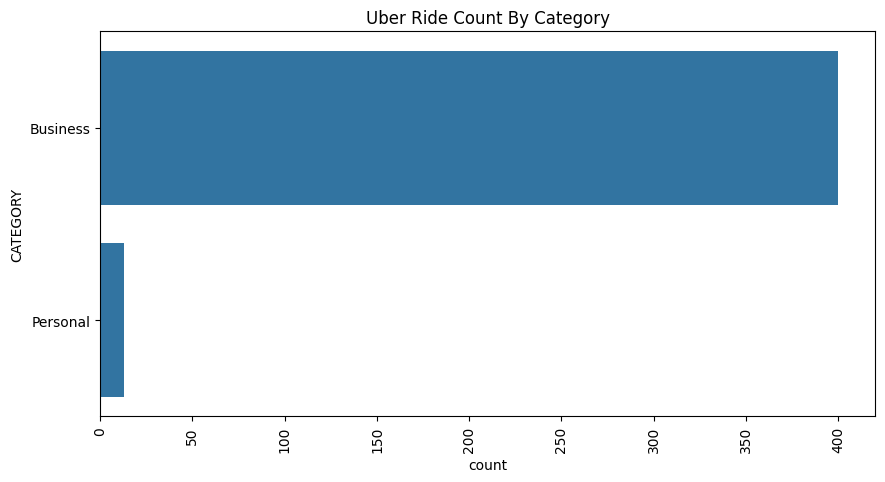

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(dataset['CATEGORY'])
plt.xticks(rotation=90)
plt.title('Uber Ride Count By Category')

plt.show()

We see that the vast majority of trips taken are for **Business**, thus the statistical significance of **Personal** trips is negligible

Now lets graph the **Purpose** column to answer the question:

What are the most common purposes for Uber rides?

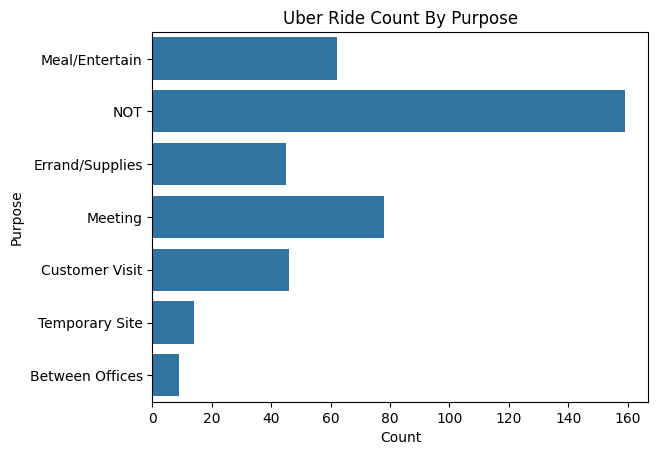

In [5]:
sns.countplot(dataset['PURPOSE'])
plt.xlabel('Count')
plt.ylabel('Purpose')
plt.title('Uber Ride Count By Purpose')
plt.show()

As we can see, most customers decided to leave the **PURPOSE** column blank, so lets exclude it from our graph

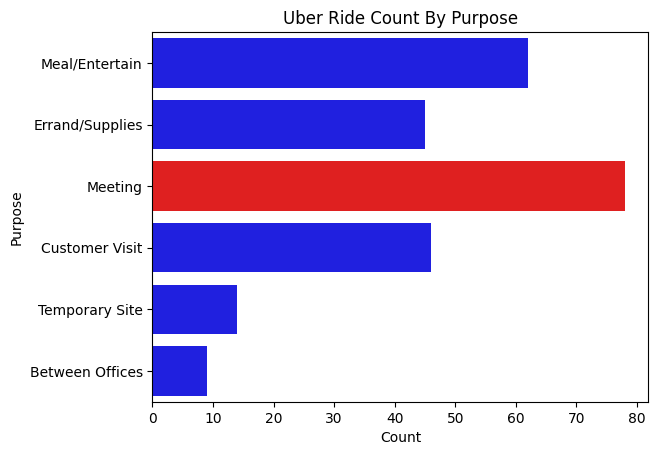

In [6]:
# remove the 'NOT' category from our results
data_wo_NOT = dataset[dataset['PURPOSE'] != 'NOT']

palette = {'Meeting': 'red',
           'Meal/Entertain' : 'blue',
           'Between Offices' : 'blue',
           'Customer Visit' : 'blue',
           'Temporary Site' : 'blue',
           'Errand/Supplies' : 'blue'}

sns.countplot(data=data_wo_NOT,
              y='PURPOSE',
              hue='PURPOSE',
              legend=False,
              palette=palette)

plt.xlabel('Count')
plt.ylabel('Purpose')
plt.title('Uber Ride Count By Purpose')

plt.show()

Now we can clearly see that the most popular reason for ordering an Uber is for **Meetings**

Now, let's break down the **day-night** column to see when the most popular time to order an Uber is on any given day:

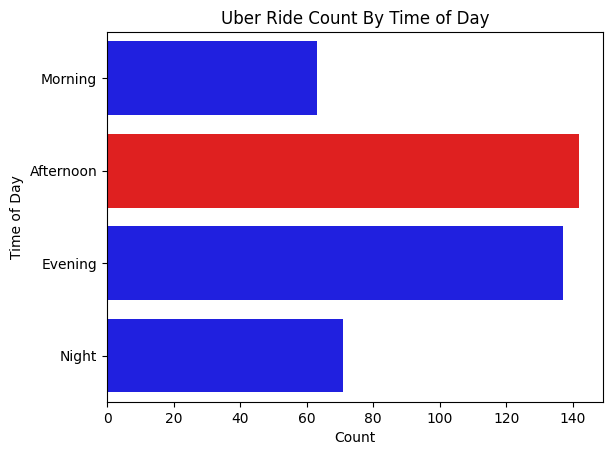

In [7]:
palette = {'Afternoon' : 'red',
           'Evening' : 'blue',
           'Night' : 'blue',
           'Morning' : 'blue',}

sns.countplot(data=dataset,
              y='day-night',
              hue='day-night',
              legend=False,
              palette=palette)

plt.xlabel('Count')
plt.ylabel('Time of Day')
plt.title('Uber Ride Count By Time of Day')

plt.show()

As we can see, most customers order an Uber in the afternoon. Earlier we defined the hours

**10:00AM - 3:00PM | Afternoon**

Now let's see what day is the most popular:

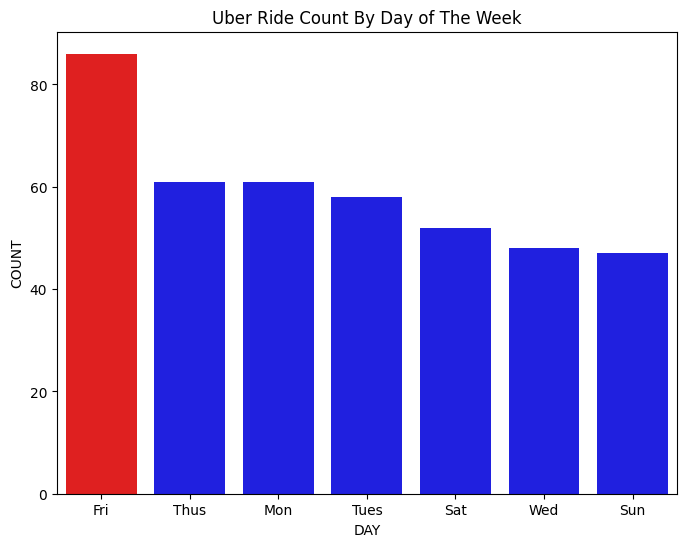

In [8]:
# Map weekdays to day labels
day_labels = {0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thus', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
dataset['DAY'] = dataset.START_DATE.dt.weekday.map(day_labels)

palette = {'Mon': 'blue', 'Tues': 'blue', 'Wed': 'blue', 'Thus': 'blue',
           'Fri': 'red', 'Sat': 'blue', 'Sun': 'blue'}

# Calculate day counts
day_counts = dataset['DAY'].value_counts()

# Create barplot with custom colors for weekdays
plt.figure(figsize=(8, 6))
sns.barplot(x=day_counts.index,
            y=day_counts.values,
            hue=day_counts.index,
            palette=palette,
            dodge=False)

plt.xlabel('DAY')
plt.ylabel('COUNT')
plt.title('Uber Ride Count By Day of The Week')

plt.show()

Now using a heatmap, we can visualize the correlation between the *time of day* and the *day of the week*:

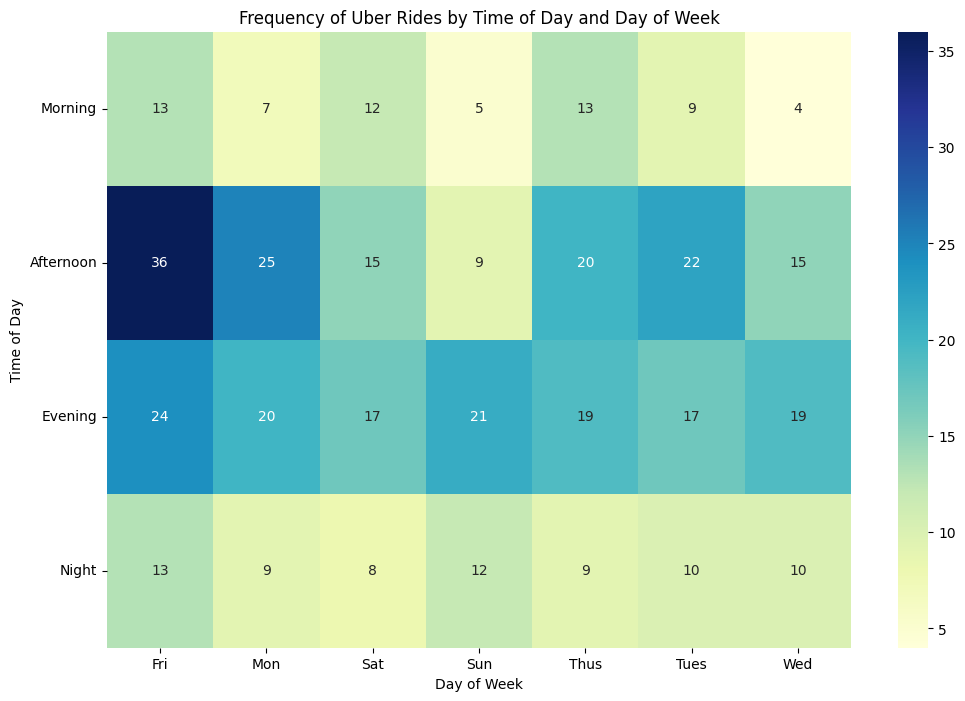

In [87]:
# Convert 'day-night' to categorical to ensure proper ordering in the heatmap
dataset['day-night'] = pd.Categorical(dataset['day-night'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)

# Count the frequency of each combination of 'day-night' and 'day_of_week'
heatmap_data = dataset.groupby(['day-night', 'DAY']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g', cbar=True)
plt.title('Frequency of Uber Rides by Time of Day and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.yticks(rotation=0)  # Ensures 'day-night' labels are horizontal
plt.show()

This heatmap tells us that the most popular time to order an Uber is **Friday Afternoon**, with most users ordering an Uber in the *Afternoon* or *Evening* regardless of the day

# Ride Metrics

Now let's visualize the average distance and duration

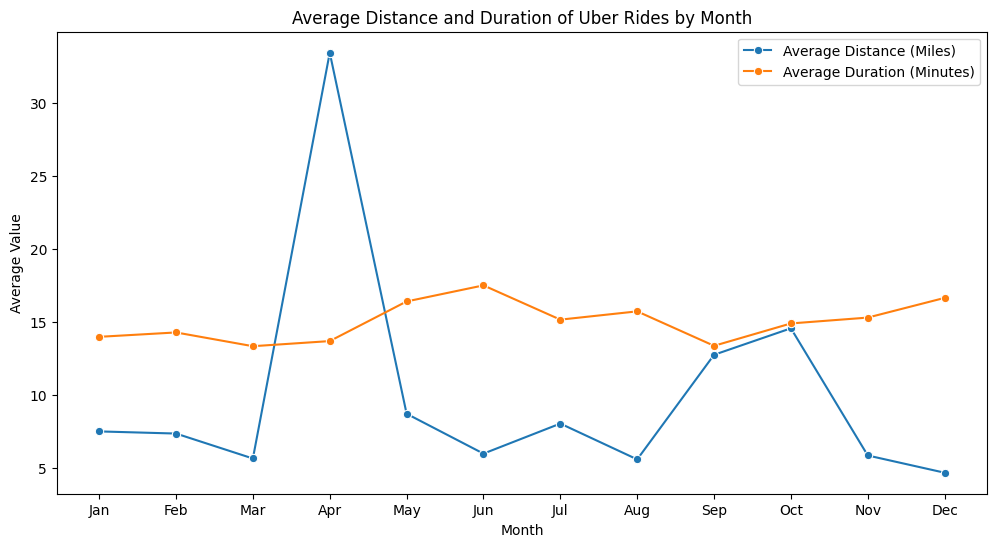

In [68]:
# extract the month component from the 'START-DATE' column
dataset['MONTH'] = pd.DatetimeIndex(dataset['START_DATE']).month

month_label = {1.0: 'Jan',
               2.0: 'Feb',
               3.0: 'Mar',
               4.0: 'Apr',
               5.0: 'May',
               6.0: 'Jun',
               7.0: 'Jul',
               8.0: 'Aug',
               9.0: 'Sep',
               10.0: 'Oct',
               11.0: 'Nov',
               12.0: 'Dec'}

# Calculate average distance per month
avg_distance_per_month = dataset.groupby('MONTH')['MILES'].mean().reset_index()
avg_distance_per_month.rename(columns={'MILES': 'AVG_DISTANCE'}, inplace=True)

# Calculate average duration per month
avg_duration_per_month = dataset.groupby('MONTH')['time'].mean().reset_index()
avg_duration_per_month.rename(columns={'time': 'AVG_DURATION_MINUTES'}, inplace=True)

# Merge average distance and duration DataFrames
avg_distance_duration_per_month = pd.merge(avg_distance_per_month, avg_duration_per_month, on='MONTH')

# Set plot size
plt.figure(figsize=(12, 6))

# Plot Average Distance
sns.lineplot(x='MONTH', y='AVG_DISTANCE', data=avg_distance_duration_per_month, marker='o', label='Average Distance (Miles)')

# Plot Average Duration
sns.lineplot(x='MONTH', y='AVG_DURATION_MINUTES', data=avg_distance_duration_per_month, marker='o', label='Average Duration (Minutes)')

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Average Distance and Duration of Uber Rides by Month')
plt.xticks(avg_distance_duration_per_month['MONTH'], [month_label[m] for m in avg_distance_duration_per_month['MONTH']])
plt.legend()

# Show plot
plt.show()


We see here that the majority of Uber Rides take **13-17 minutes** to complete, with an average distance of **<10 miles** *except* for the months of April, where we see an outlier for an average ride distance of **over 30 miles**, and again some longer rides in September/October at **13-15 miles**.


Lets look at a boxplot of all the distances recorded in the dataset to have a better understanding of our outliers.

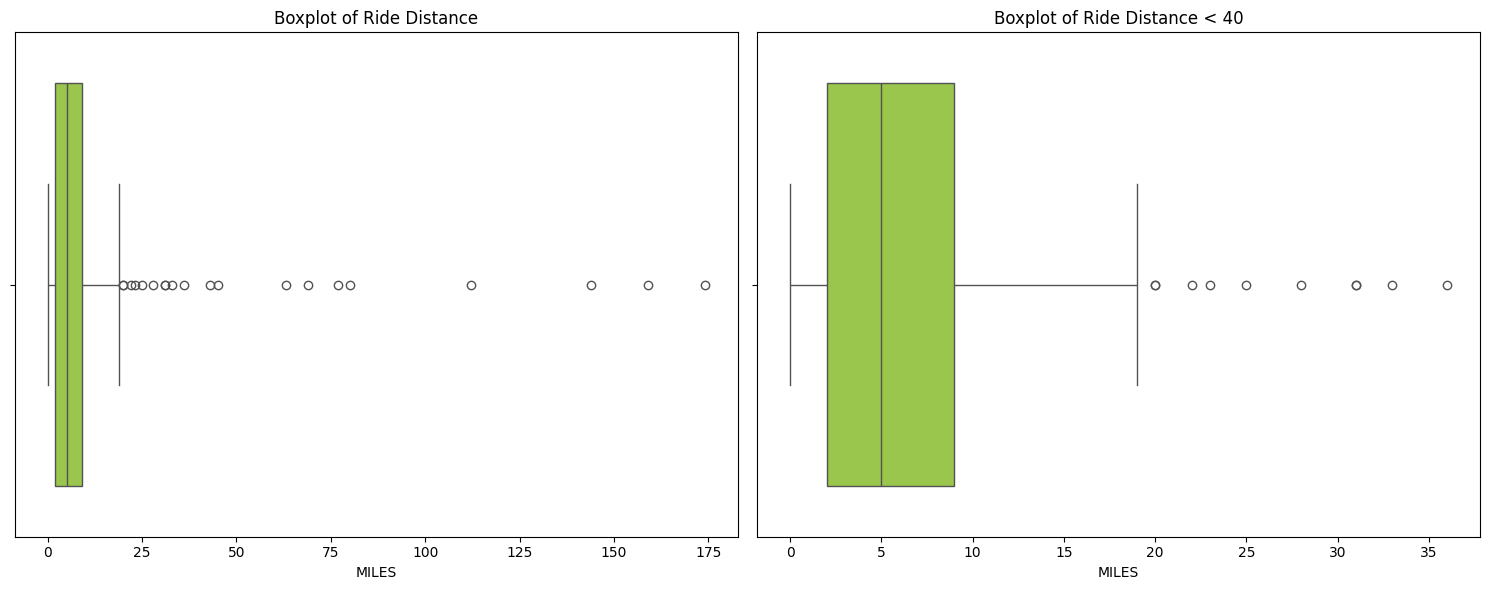

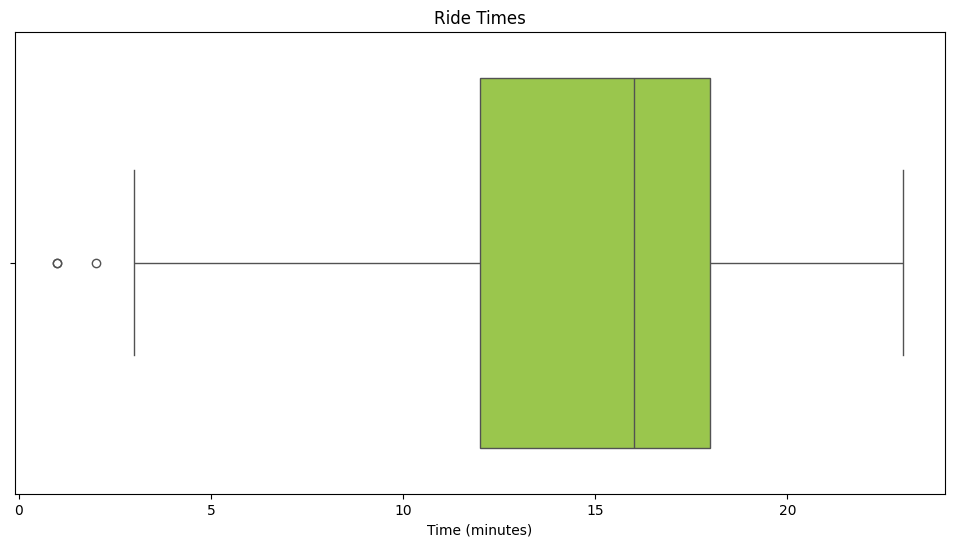

In [217]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='MILES',
            data=dataset,
            ax=axes[0])
axes[0].set_title('Boxplot of Ride Distance')

sns.boxplot(x='MILES',
            data=dataset[dataset['MILES'] < 40],
            ax=axes[1])
axes[1].set_title('Boxplot of Ride Distance < 40')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

sns.boxplot(x='time',
            data=dataset)
plt.title('Ride Times')
plt.xlabel('Time (minutes)')
plt.show()

Here we see that there are lots of outliers in the **MILES** column, so shifting our focus to rides that that are *40 miles or less* shows that the majority of rides are actually within **20 miles.**

Our IQR indicates that 50% of rides are only **3-10 miles**.

Interestingly enough, we have far less outliers for ride times.

We also see an IQR of **12-18 minutes** for our Ride Time boxplot.


Now that we see that our outliers begin after 40 miles, lets examine the data with a fresh perspective by only examining the rides with distances 40 miles or less.

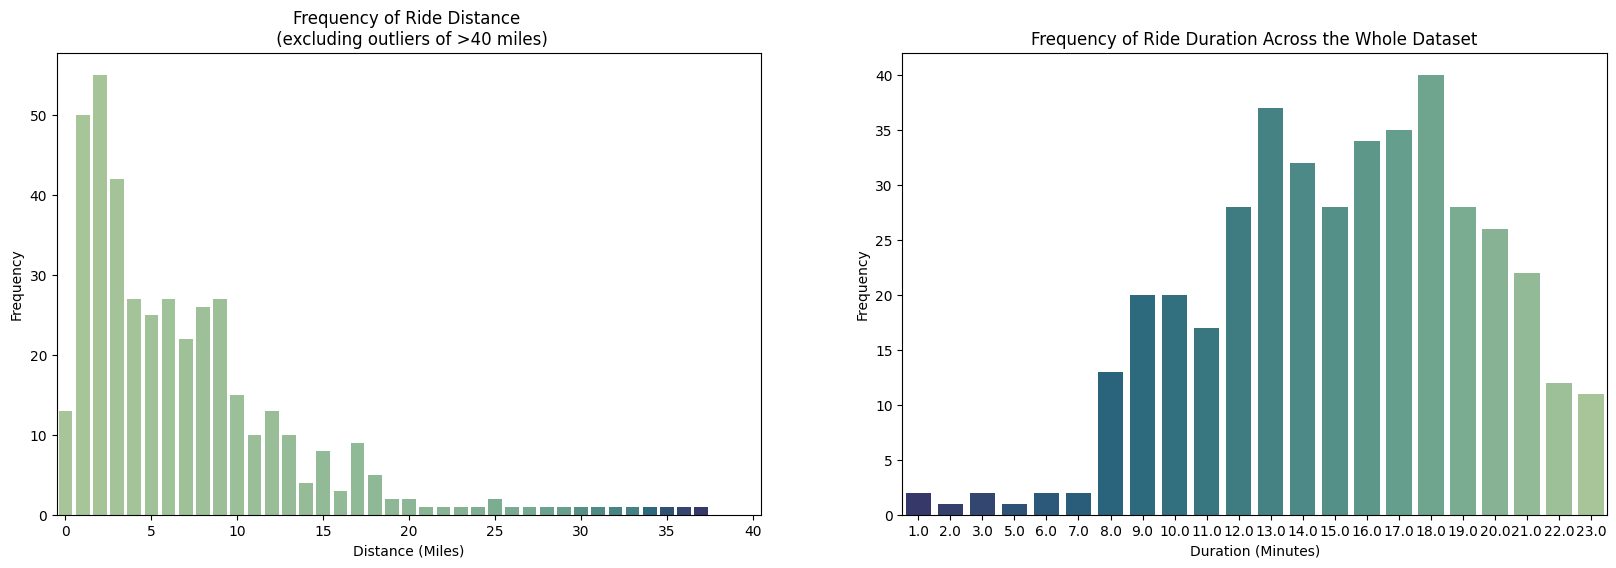

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot Overall Distance
sns.countplot(x='MILES',
              hue='MILES',
              data=dataset,
              legend=False,
              palette='crest',
              ax=axes[0])

# Set plot labels and title
axes[0].set_title('Frequency of Ride Distance \n (excluding outliers of >40 miles)')
axes[0].set_xlabel('Distance (Miles)')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, dataset['MILES'].max() + 1, 5))  # Set ticks every 5 miles
axes[0].set_xticklabels(range(0, dataset['MILES'].max() + 1, 5))  # Set labels for ticks
axes[0].set_xlim(-0.5, 40.5)

# Plot OveraLL Duration
sns.countplot(x='time',
              hue='time',
              data=dataset,
              legend=False,
              palette='crest_r',
              ax=axes[1])

# Set plot labels and title
axes[1].set_title('Frequency of Ride Duration Across the Whole Dataset')
axes[1].set_xlabel('Duration (Minutes)')
axes[1].set_ylabel('Frequency')

# Show plot
plt.show()


Again we see that most rides are even less than 10 miles, with the most common distance for rides actually being **1-3 miles**. This tells us that a majority of Uber rides are very short, at least in distance.

Now lets use a scatterplot to understand the correlation between ride distance and duration across the whole dataset


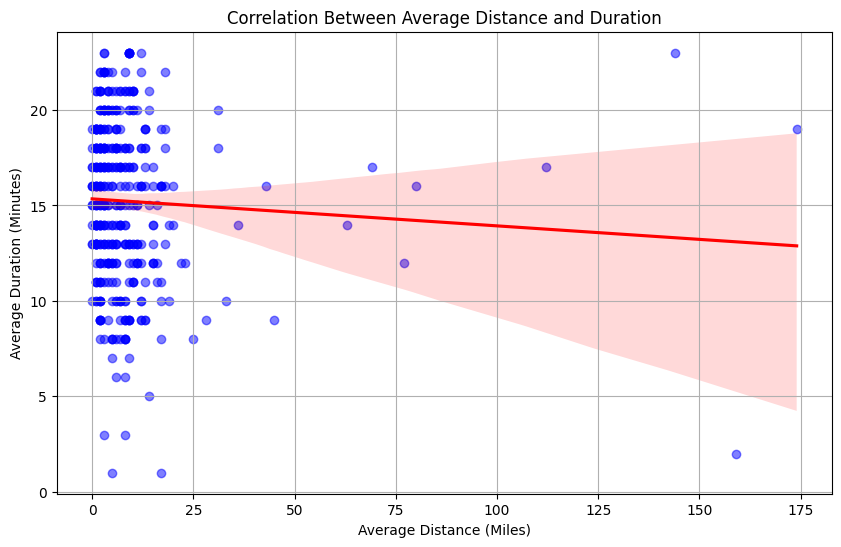

In [220]:
plt.figure(figsize=(10, 6))
sns.regplot(x='MILES',
            y='time',
            data=dataset,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'},
            color='blue',
            marker='o')
plt.title('Correlation Between Average Distance and Duration')
plt.xlabel('Average Distance (Miles)')
plt.ylabel('Average Duration (Minutes)')
plt.grid(True)
plt.show()

While we see that the regression line trends *downwards*, overall we see no real correlation between ride distance and duration as the scatterplot shows us that rides with an average distance of **0-25 miles** have an approximate range of **5-25 minutes**, which dosent tell us a whole lot.

With no real correlation established between ride distance and duration, lets see if there are any trends assosciated with the purposes of each ride (I am also choosing to exclude the 'NOT' category again for simplicity)

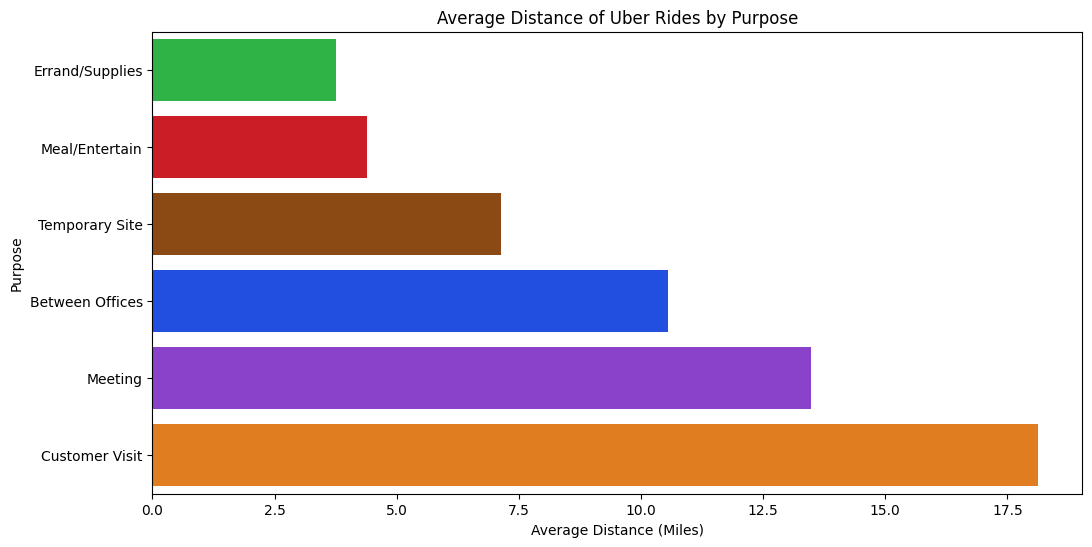

In [107]:
# Filter the dataset to exclude rows where 'PURPOSE' is 'NOT'
filtered_dataset = dataset[dataset['PURPOSE'] != 'NOT']

# Calculate average distance for each purpose
avg_distance_by_purpose = filtered_dataset.groupby('PURPOSE')['MILES'].mean().reset_index()

# Set plot size
plt.figure(figsize=(12, 6))

# Create barplot
sns.barplot(x='MILES',
            y='PURPOSE',
            hue='PURPOSE',
            data=avg_distance_by_purpose,
            order=avg_distance_by_purpose.sort_values('MILES')['PURPOSE'],
            legend=False,
            palette='bright')

# Set plot labels and title
plt.xlabel('Average Distance (Miles)')
plt.ylabel('Purpose')
plt.title('Average Distance of Uber Rides by Purpose')

# Show plot
plt.show()


We see that **Customer Visits** account for the longest rides on average, but remember we have *MASSIVE* outliers in our dataset, let's see what happens when we filter for distance

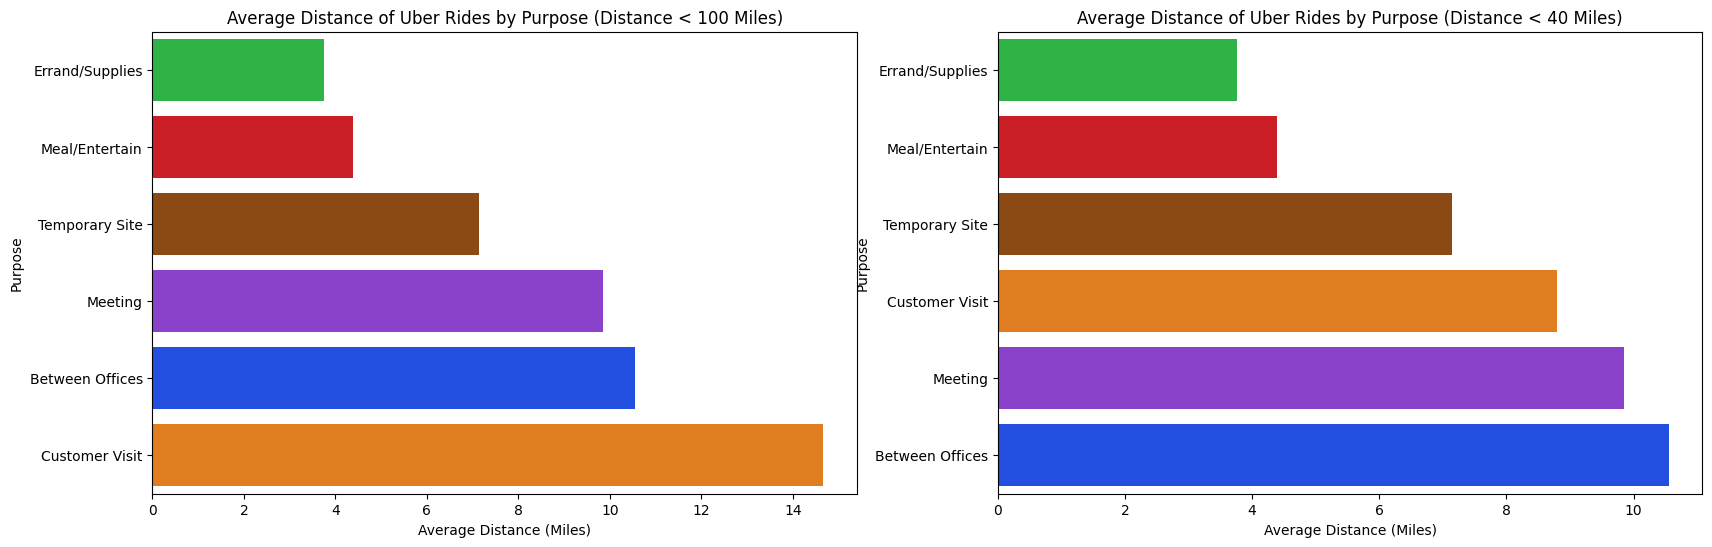

In [105]:
# Filter the dataset to include only rows where 'MILES' is below 40 and 100
filtered_dataset_40 = dataset[(dataset['MILES'] < 40) & (dataset['PURPOSE'] != 'NOT')]
filtered_dataset_100 = dataset[(dataset['MILES'] < 100) & (dataset['PURPOSE'] != 'NOT')]

# Calculate average distance for each purpose
avg_distance_by_purpose_40 = filtered_dataset_40.groupby('PURPOSE')['MILES'].mean().reset_index()
avg_distance_by_purpose_100 = filtered_dataset_100.groupby('PURPOSE')['MILES'].mean().reset_index()

# Set plot size
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Create barplot for Distance < 100 Miles
sns.barplot(x='MILES',
            y='PURPOSE',
            hue='PURPOSE',
            data=avg_distance_by_purpose_100,
            order=avg_distance_by_purpose_100.sort_values('MILES')['PURPOSE'],  # Order by average distance
            ax=axes[0],
            palette='bright')

# Set plot labels and title for Distance < 100 Miles
axes[0].set_xlabel('Average Distance (Miles)')
axes[0].set_ylabel('Purpose')
axes[0].set_title('Average Distance of Uber Rides by Purpose (Distance < 100 Miles)')

# Create barplot for Distance < 40 Miles
sns.barplot(x='MILES',
            y='PURPOSE',
            hue='PURPOSE',
            data=avg_distance_by_purpose_40,
            order=avg_distance_by_purpose_40.sort_values('MILES')['PURPOSE'],  # Order by average distance
            ax=axes[1],
            palette='bright')

# Set plot labels and title for Distance < 40 Miles
axes[1].set_xlabel('Average Distance (Miles)')
axes[1].set_ylabel('Purpose')
axes[1].set_title('Average Distance of Uber Rides by Purpose (Distance < 40 Miles)')

# Show plot
plt.show()


First we filter for rides with **<100 miles** in distance, and again for **<40 miles**.

When we filter for rides **<100 miles** in distance we see that commuting *Between Offices* overtakes commuting for *Meetings*, with *Customer Visits* being the category with the longest average rides still

However, filtering for rides **<40 miles** shows us something intersting, we see that both the *Meeting* and the *Between Offices* categories now overtake *Customer Visit*.

From this we can conclude that the outliers for ride distance must come from the **Meeting** and **Customer Visit** categories...

Lets verify this real quick:

In [128]:
# Filter dataset for the desired categories
filtered_dataset = dataset[dataset['PURPOSE'].isin(['Customer Visit', 'Meeting'])]

# Group the filtered dataset by 'PURPOSE' and get the top 3 distances for each category
top_distances_by_purpose = (filtered_dataset.groupby('PURPOSE')['MILES']
                            .apply(lambda x: x.nlargest(10))
                            .reset_index(name='Distance'))

# Reset index and drop the 'level_1' column
top_distances_by_purpose_cleaned = top_distances_by_purpose.reset_index(drop=True).drop(columns='level_1')

# Convert the DataFrame to a string with a nice format
output_str = top_distances_by_purpose_cleaned.to_string(index=False)

print(output_str)

       PURPOSE  Distance
Customer Visit       174
Customer Visit        80
Customer Visit        77
Customer Visit        63
Customer Visit        45
Customer Visit        43
Customer Visit        36
Customer Visit        23
Customer Visit        19
Customer Visit        18
       Meeting       159
       Meeting       144
       Meeting        25
       Meeting        20
       Meeting        19
       Meeting        18
       Meeting        18
       Meeting        17
       Meeting        17
       Meeting        17


Just as expected, we see that the Customer Visit and the Meeting category are the two categories that contain the **most outliers**.

In [129]:
# Filter dataset for the desired categories
filtered_dataset = dataset[dataset['PURPOSE'].isin(['Customer Visit',
                                                    'Meeting',
                                                    'Between Offices',
                                                    'Temporary Site',
                                                    'Meal/Entertain',
                                                    'Errand/Supplies'])]

# Group the filtered dataset by 'PURPOSE' and get the top 3 distances for each category
top_distances_by_purpose = (filtered_dataset.groupby('PURPOSE')['MILES']
                            .apply(lambda x: x.nlargest(3))
                            .reset_index(name='Distance'))

# Reset index and drop the 'level_1' column
top_distances_by_purpose_cleaned = top_distances_by_purpose.reset_index(drop=True).drop(columns='level_1')

# Convert the DataFrame to a string with a nice format
output_str = top_distances_by_purpose_cleaned.to_string(index=False)

print(output_str)

        PURPOSE  Distance
Between Offices        20
Between Offices        13
Between Offices        12
 Customer Visit       174
 Customer Visit        80
 Customer Visit        77
Errand/Supplies        22
Errand/Supplies        15
Errand/Supplies        14
 Meal/Entertain        17
 Meal/Entertain        14
 Meal/Entertain         9
        Meeting       159
        Meeting       144
        Meeting        25
 Temporary Site        13
 Temporary Site        12
 Temporary Site         9


Comparing again with the rest of the categories we confirm that the outliers belong solely to those two categories.

# Geographical Insights

Now let's take a look at the most popular **routes** for Uber Rides

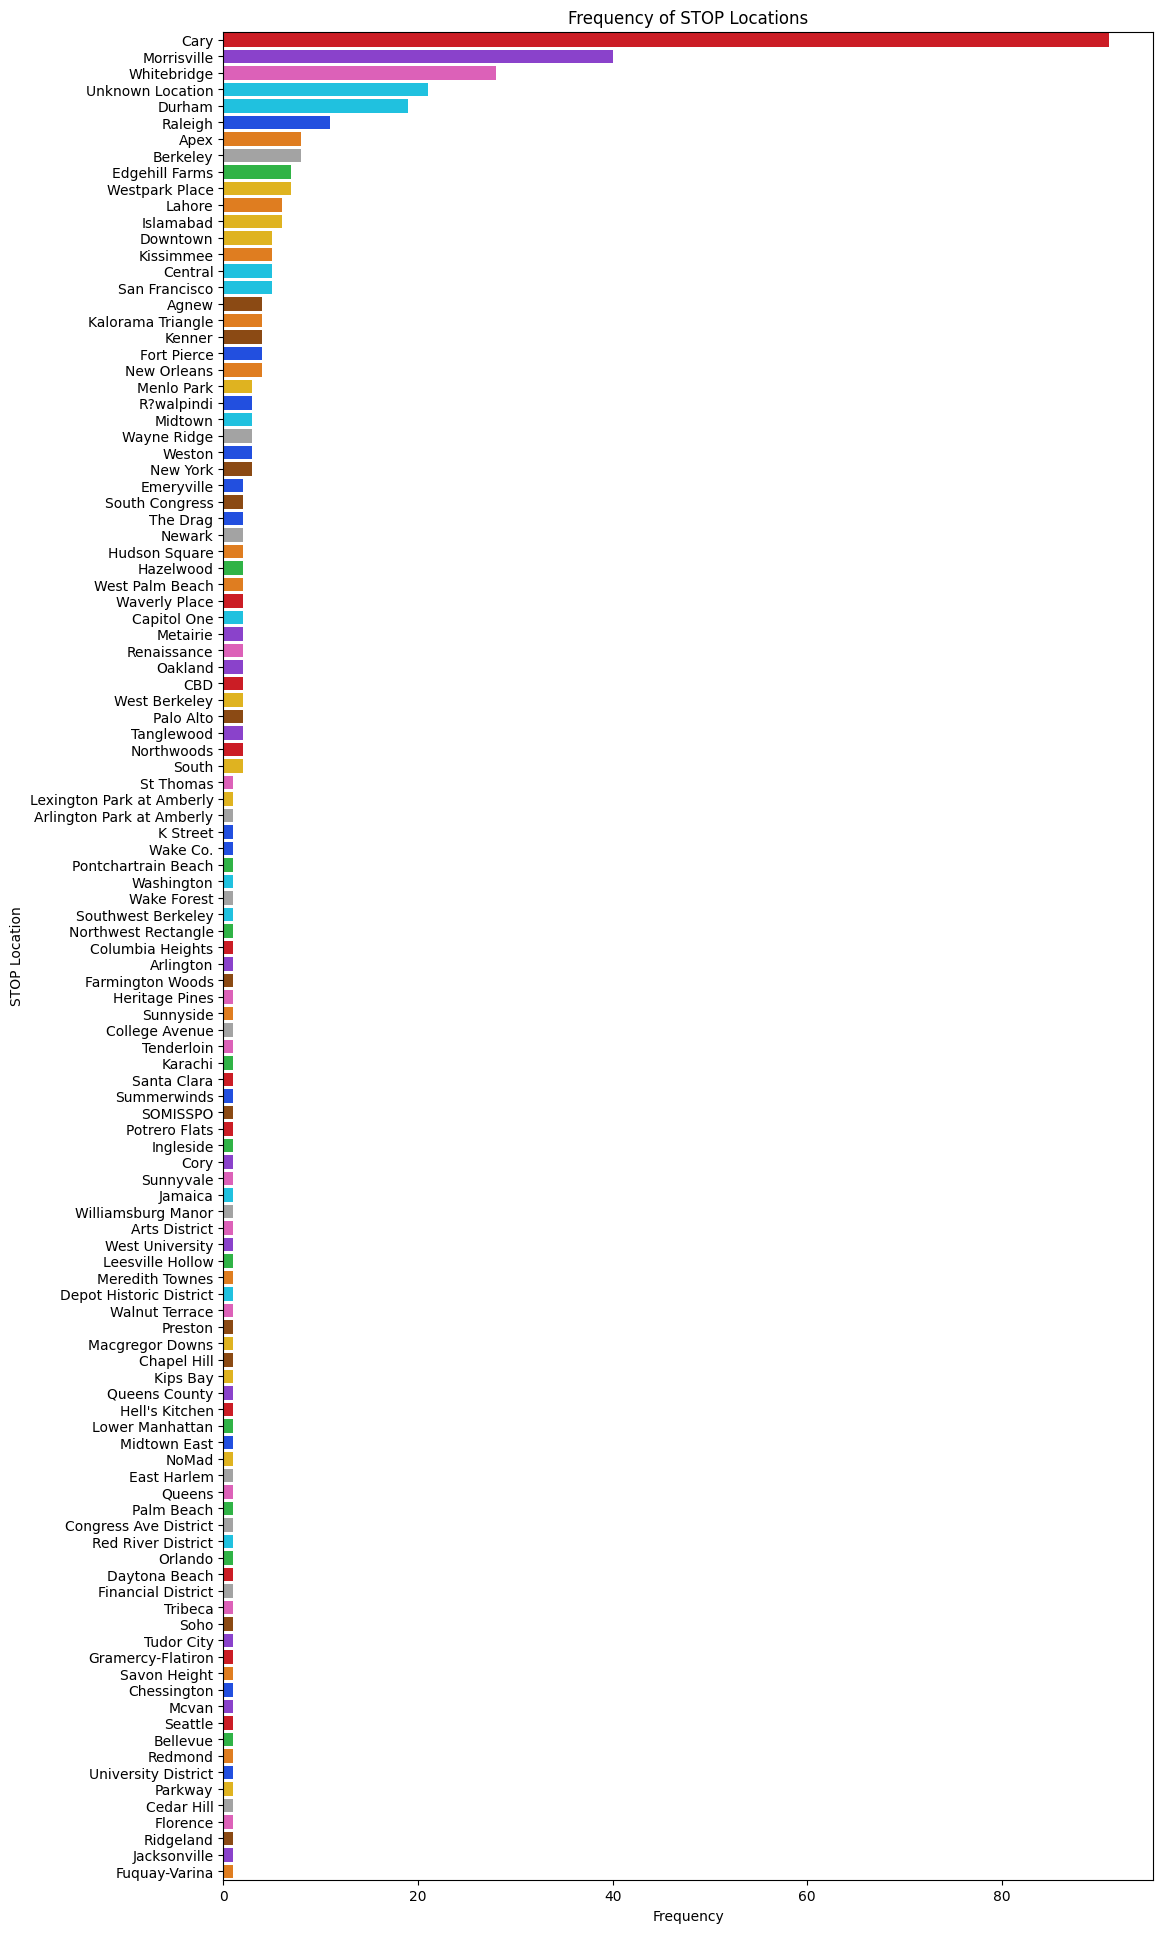

In [174]:
# Set plot size
plt.figure(figsize=(12, 24))

# Create countplot for STOP locations
sns.countplot(y='STOP',
              hue='STOP',
              data=dataset,
              order=dataset['STOP'].value_counts().index,
              palette='bright')

# Set plot labels and title
plt.xlabel('Frequency')
plt.ylabel('STOP Location')
plt.title('Frequency of STOP Locations')

# Show plot
plt.show()

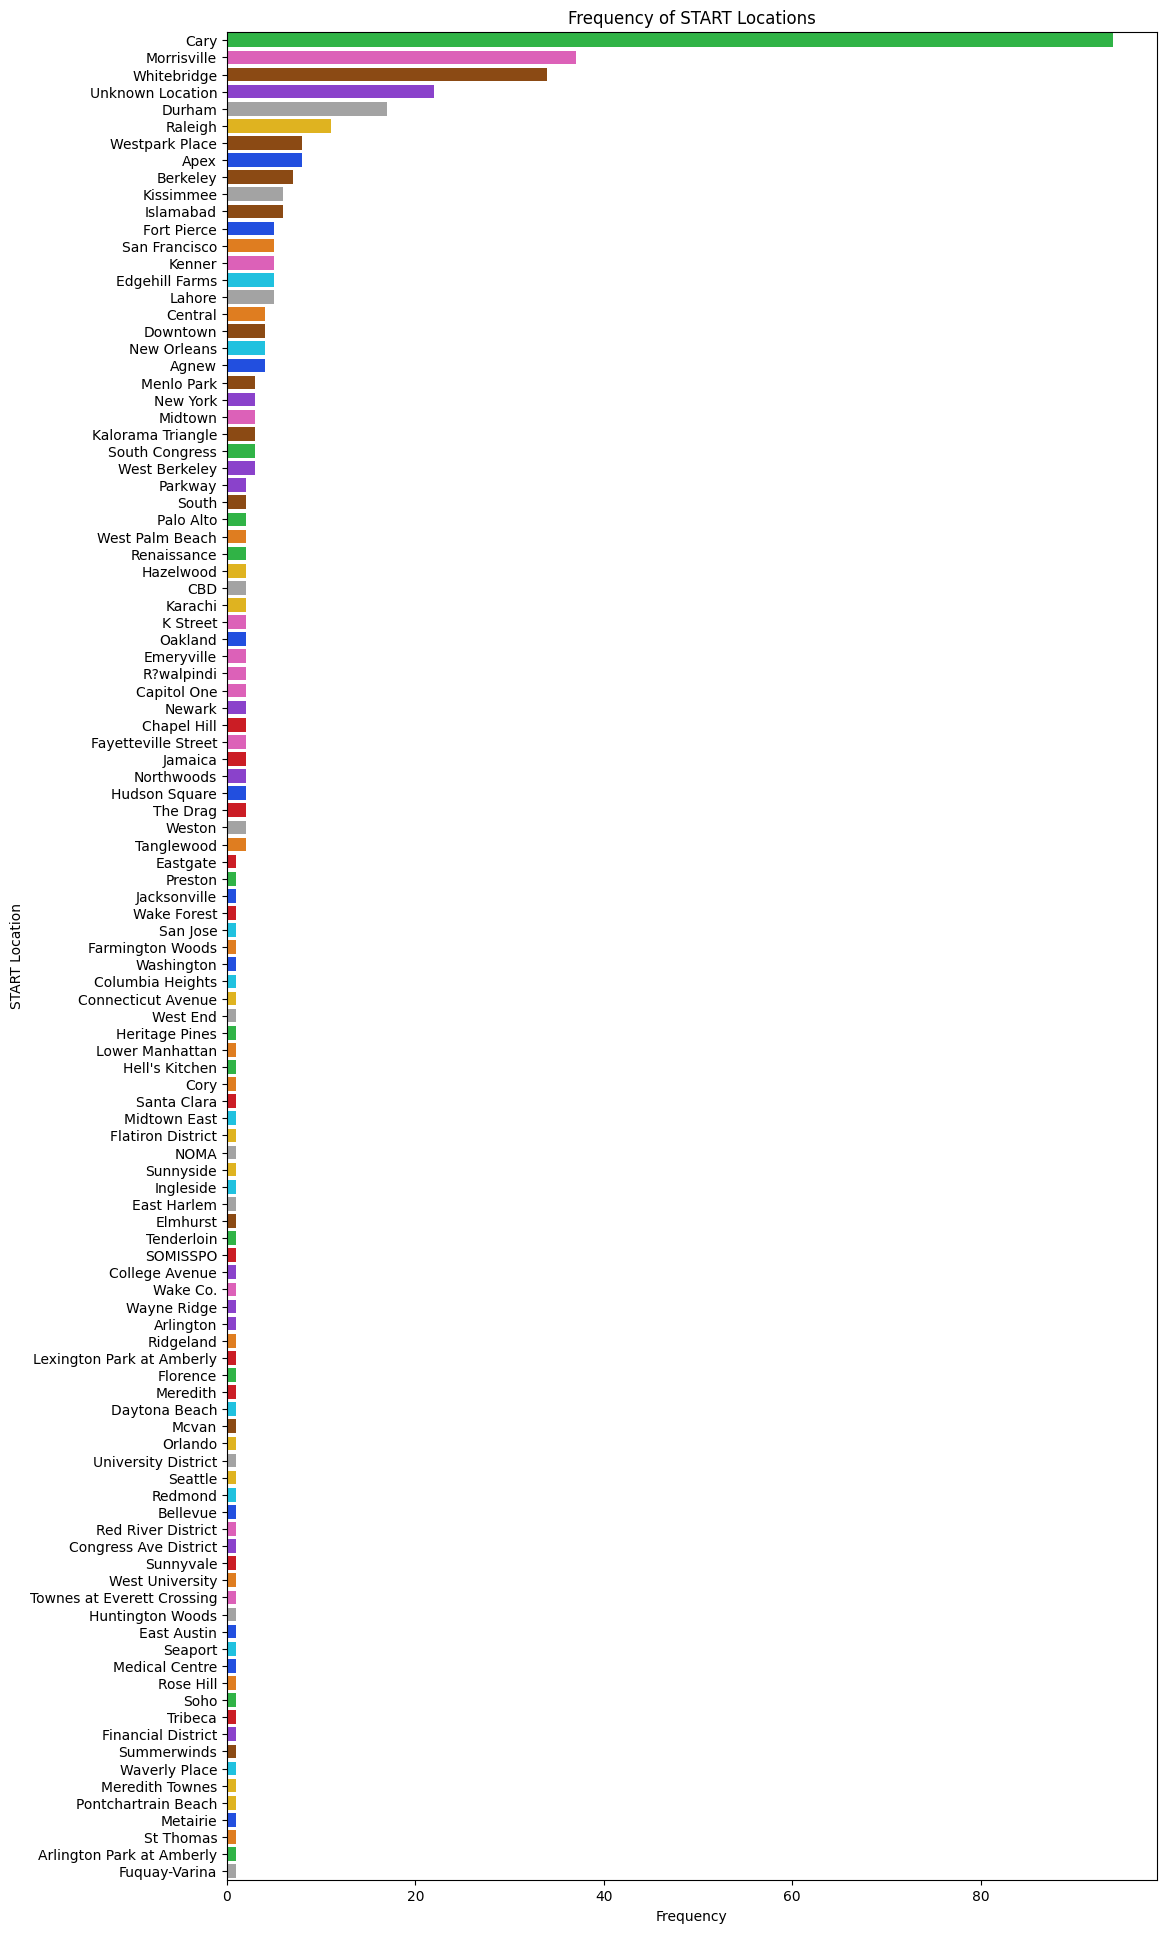

In [181]:
# Set plot size
plt.figure(figsize=(12, 24))

# Create countplot for STOP locations
sns.countplot(y='START',
              hue='START',
              data=dataset,
              order=dataset['START'].value_counts().index,
              palette='bright')

# Set plot labels and title
plt.xlabel('Frequency')
plt.ylabel('START Location')
plt.title('Frequency of START Locations')

# Show plot
plt.show()

We see that the majority of Uber ride data gathered in this dataset revolves around North Carolina where the cities of ***Cary, Morrisville, Whitebridge, Durham, Apex,*** and ***Raleigh*** are located.

With that being established, *take the results of this analysis with a grain of salt*, as this may not be representative of the whole country, or even the whole state of North Carolina.

By defining a *'Route'* as a count of unique combinations of Start/Stop locations we can understand a little better where people are leaving ***from*** and heading ***to***

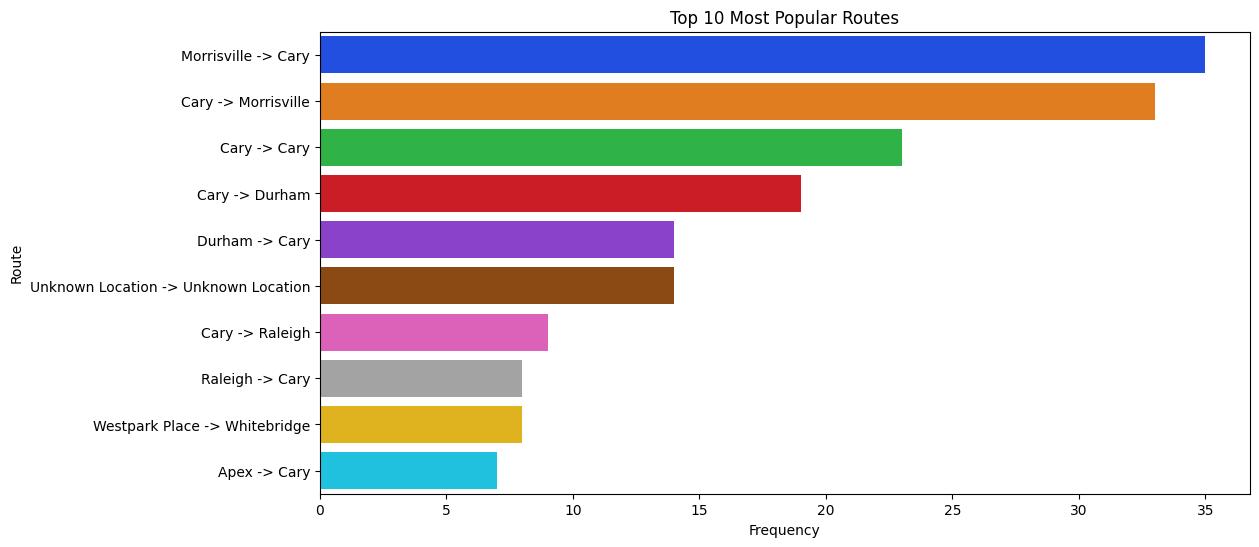

In [183]:
# Create a new column 'ROUTE' that combines START and STOP locations
dataset['ROUTE'] = dataset[['START', 'STOP']].apply(lambda x: ' -> '.join(x), axis=1)

# Count the frequency of each unique route
route_counts = dataset['ROUTE'].value_counts().reset_index()
route_counts.columns = ['ROUTE', 'FREQUENCY']

# Select top 10 most popular routes
top_10_routes = route_counts.head(10)

# Set plot size
plt.figure(figsize=(12, 6))

# Create countplot for top 10 routes
sns.barplot(x='FREQUENCY',
            y='ROUTE',
            hue='ROUTE',
            data=top_10_routes,
            palette='bright')

# Set plot labels and title
plt.xlabel('Frequency')
plt.ylabel('Route')
plt.title('Top 10 Most Popular Routes')

# Show plot
plt.show()


As expected, most Uber Rides in this dataset revolve around the "Research Triangle area in North Carolina, informally recognized as the intersection between three research universities, NC State, UNC Chapel Hill, and Duke University, and their overarching metroplitana reas of Raleigh, Durham, Morrisville, Cary and Whitebridge

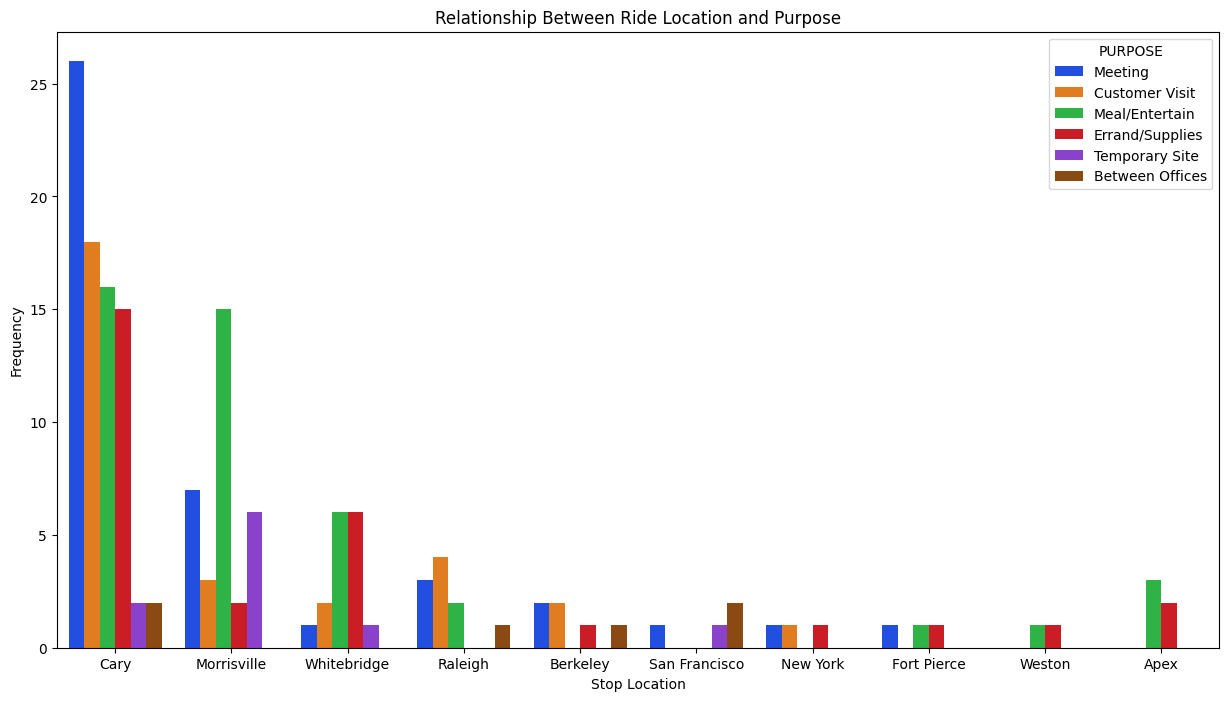

In [200]:
# Filter out rows where 'PURPOSE' is 'NOT'
filtered_dataset = dataset[dataset['PURPOSE'] != 'NOT']

# Group the filtered data by 'STOP' and 'PURPOSE' and count the occurrences
purpose_counts_by_stop = filtered_dataset.groupby(['STOP', 'PURPOSE']).size().reset_index(name='FREQUENCY')

# Sort the data by 'FREQUENCY' in descending order
purpose_counts_by_stop = purpose_counts_by_stop.sort_values(by='FREQUENCY', ascending=False).reset_index(drop=True)

# Get the top ten STOP locations based on frequency counts
top_ten_stops = purpose_counts_by_stop['STOP'].value_counts().nlargest(10).index

# Filter the purpose_counts_by_stop DataFrame to include only the top ten STOP locations
purpose_counts_by_stop = purpose_counts_by_stop[purpose_counts_by_stop['STOP'].isin(top_ten_stops)]

# Set plot size
plt.figure(figsize=(15, 8))

# Create countplot for frequency of 'PURPOSE' categories for each 'STOP' location
sns.barplot(x='STOP',
            y='FREQUENCY',
            hue='PURPOSE',
            data=purpose_counts_by_stop,
            order=top_ten_stops,
            palette='bright')

plt.xlabel('Stop Location')
plt.ylabel('Frequency')
plt.title('Relationship Between Ride Location and Purpose')

plt.show()

Excluding the 'NOT' category again, we now examine the correlation between ride **location** and **purpose**.

Unsurprisingly, the most common purpose for rides ending in Cary are for **Meetings**, as earlier we defined Meetings to be the most common purpose for Uber rides across the entire dataset, with Cary accounting for roughly **1/3** of Meetings in the ***entire dataset***.

**Meal/Entertainment** was the second most common Purpose in the dataset, and again, we see that Cary and Morrisville account for a *significant* portion of that data.

Interestingly, Cary is the only destination on the list that has riders traveling there for all purposes listed.

# Seasonal Trends

Finally, let's see if we can determine when is the most popular time of year to order an Uber

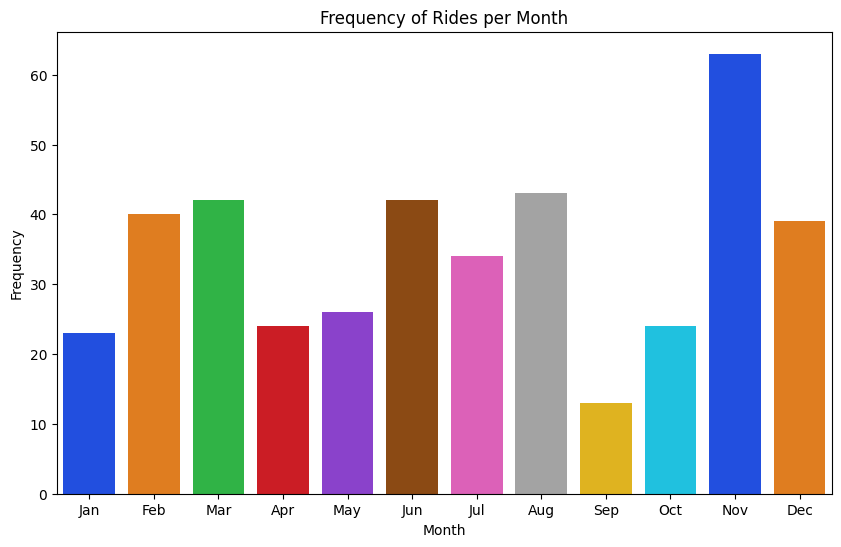

In [207]:
# extract the month component from the 'START-DATE' column
dataset['MONTH'] = pd.DatetimeIndex(dataset['START_DATE']).month

month_label = {1.0: 'Jan',
               2.0: 'Feb',
               3.0: 'Mar',
               4.0: 'Apr',
               5.0: 'May',
               6.0: 'Jun',
               7.0: 'Jul',
               8.0: 'Aug',
               9.0: 'Sep',
               10.0: 'Oct',
               11.0: 'Nov',
               12.0: 'Dec'}

# Map month numbers to month names
dataset['MONTH'] = dataset['MONTH'].map(month_label)

# Count the number of rides per month
rides_per_month = dataset['MONTH'].value_counts().reset_index()
rides_per_month.columns = ['MONTH', 'FREQUENCY']

# Set plot size
plt.figure(figsize=(10, 6))

# Create countplot for frequency of rides per month
sns.countplot(x='MONTH',
              hue='MONTH',
              data=dataset,
              order=month_label.values(),
              palette='bright')

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Frequency of Rides per Month')

plt.show()

We can see here that most rides are ordered in **November**, almost **65 rides** as compared to the next most popular month of **August** with roughly **45 rides** ordered

February, March, June, and December seem to be popular months as well.

There does not seem to be a seasonal trend with ride frequency, but we do get an idea of when are the most/least popular times to order an Uber